# Sesion 1: Taller de tecnicas de modelado computacional de fluidos

## Elementos Finitos: Metodo Galerkin Discontinuo

**Por: Erick Urquilla, Universidad de Tennessee, Knoxville, USA**

Resolveremos las ecuaciones que gobiernan la dinámica de fluidos poco profundos incompresibles. El fluido está limitado inferiormente y a los costados por superficies rígidas y superiormente sin restricción. Estas ecuaciones se derivan de las ecuaciones de Navier-Stokes cuando el dominio espacial horizontal del fluido excede significativamente al vertical, manteniendo el equilibrio hidrostático y densidad constante:

$$
\frac{\partial h}{\partial t} + \frac{\partial}{\partial x}\left(hu\right) = 0
$$
$$
\frac{\partial}{\partial t}\left(hu\right) + \frac{\partial}{\partial x}\left(hu^2 + \frac{gh^2}{2}\right) = 0
$$

Aquí, $h$ es la altura del fluido, $u$ es la velocidad horizontal y $g$ es la aceleración de la gravedad. El movimiento del fluido está dictado exclusivamente por las ecuaciones de conservación de masa y momento.

## Paquetes utilizados

En este proyecto, utilizaremos varios paquetes de Python que nos ayudarán a realizar diferentes tareas de manera eficiente. A continuación, se describen los paquetes que se utilizarán:

1. **numPy**
2. **matplotlib**
3. **IPython**
4. **time**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import time

## Scripts utilizados

En esta sesion importaremos los siguientes scripts

1. **basis.py**
2. **discontinuos_galerkin.py**
3. **time_stepping.py**
4. **plots.py**

Puedes encontrar estos scripts en la misma ruta que este notebook

In [2]:
# !git clone --branch curso_unah_sesion_1 --single-branch https://github.com/erickurquilla1999/1D-Shallow-Water-Equation.git
# !mv 1D-Shallow-Water-Equation/*.py ./

import basis
import discontinuos_galerkin 
import time_stepping
import plots

## Parámetros de entrada

1. Dominio espacial de la simulación
2. Número de elementos y número de nodos interiores por elemento
3. Tiempo de la simulación y número de pasos
4. Número de puntos en la cuadratura de Gauss para integración numérica

In [3]:
# Parametros de entrada

# Dominio espacial de la simulacion 
x_inicial = 0 # (m) cooordenda inicial del dominio
x_final = 10 # (m) coordenada final del dominio

# Parametros del metodo de elementos finitos
N_elementos = 6 # numero de elementos
N_nodos = 4 # numero de nodos por elemento (por simplicidad solo consideramos N_nodos >= 2)

# Dominio temporal 
n_pasos = 100 # numero de pasos temporales
t_total = 1 # (s) tiempo final

# Integracion numerica con cuadratura de Gauss
n_nodos_cuadratura_gauss = 20

# Variables utiles
longitud_elemento = (x_final - x_inicial) / N_elementos

## Generacion de malla

La generación de una malla es fundamental en el método de elementos finitos. La malla divide el dominio espacial en elementos finitos más pequeños, lo que permite aproximar la solución de la ecuación diferencial en cada uno de estos elementos. En el método Galerkin Discontinuo, cada elemento puede tener su propia solución polinómica, lo que permite capturar discontinuidades y variaciones abruptas en las variables del fluido.

**Ejercicio 1:** Dadas las coordenadas inicial `x_inicial`, coordenada final `x_final`, el número de elementos `N_elementos` y el número de nodos por elemento `N_nodos`. Codifica una malla cartesiana unidimensional con las coordenadas de los nodos interiores de cada elemento (elementos y nodos igualmente espaciados en una malla regular). El numpy array resultado del ejercicio debe llamarse `malla`. La forma del array `malla` debe ser `(N_elementos, N_nodos)`. Es decir, el componente `malla[i,j]` representa la coordenada en `x` del nodo `j` del elemento `i`. 

Como ejemplo, observa la siguiente imagen de una `malla` con `N_elementos=3` y `N_nodos=4`. El arreglo `malla` contiene las posiciones de los nodos interiores de cada elemento.

![Malla](imagenes/malla.png)

In [4]:
print(f'Generando malla \nDominio físico: [{x_inicial},{x_final}] metros\nNúmero de elementos: {N_elementos}\nNodos por elemento: {N_nodos}\n')

# Generar coordenadas de los elementos y nodos en el espacio físico
malla = np.zeros((N_elementos, N_nodos)) # nunpy array que almacenara las coordenadas de los nodos de cada elemento

#-----------------------------------------------------------------------------------------
# Escribe tu solucion al ejercicio 1 a continuacion ...
malla = np.array([np.linspace(x_inicial + i * (x_final - x_inicial) / N_elementos, x_inicial + (i + 1) * (x_final - x_inicial) / N_elementos, N_nodos) for i in range(N_elementos)])      
#-----------------------------------------------------------------------------------------

Generando malla 
Dominio físico: [0,10] metros
Número de elementos: 6
Nodos por elemento: 4



## Condiciones Iniciales

Las condiciones iniciales del fluido están dadas por:

$$h_0 = 1 + 0.1 e^{-(x-5)^2}$$
$$u_0 = 0$$

Las fronteras del fluido están ubicadas en $x = 0$ y $x = 10$ metros.

**Ejercicio 2:** Crea dos arrays de numpy que contengan las condiciones iniciales:

1. El primer array debe llamarse `h` y tener la forma `(N_elementos, N_nodos)`. `h[i,j]` representará la altura en metros del fluido en el nodo $j$ del elemento $i$.
2. El segundo array debe llamarse `u` y tener la forma `(N_elementos, N_nodos)`. `u[i,j]` representará la velocidad en metros por segundo del fluido en el nodo $j$ del elemento $i$.

In [5]:
# Generando condiciones iniciales
h = np.zeros((N_elementos, N_nodos)) # Height (cm)
u = np.zeros((N_elementos, N_nodos)) # Velocity (cm/s)

#-----------------------------------------------------------------------------------------
# Escribe tu solucion al ejercicio 2 a continuacion ...
h = 1.0 + 0.1 * np.exp( - ( malla - 5.0 )**2 ) # Height (cm)
u = malla * 0.0 # Velocity (cm/s)
#-----------------------------------------------------------------------------------------

## Aproximación funcional de la solución: Polinomios de Lagrange

Para crear una solución funcional a la ecuación de agua profunda, usaremos los polinomios de Lagrange definidos como
$$
\phi_i(x) = \prod_{\substack{0 \leq m \leq p \\ m \neq i}} \frac{x - x_m}{x_i - x_m}.
$$
Aquí, $x_i$ es la posición del nodo $i$. 

Los polinomios de Lagrange tienen la siguiente propiedad:
$$
\phi_i(x_j) = \delta_{ij}.
$$
Utilizando los polinomios de Lagrange, una solución funcional en el elemento $k$ puede escribirse como
$$
u^{k}(t,x) = \sum_{i=0}^{N} U^{k}_{i}(t)\phi_{i}^k(x),
$$
donde $N$ es el número de nodos en el elemento $k$.

**Ejercicio 3:** Escriba una función que, dados los nodos de un elemento, el índice $i$ del polinomio de Lagrange y una posición $x$, retorne el polinomio de Lagrange $i$ evaluado en $x$.


In [6]:
def polinomios_de_lagrange(nodos, i, x):
    '''
    Dado un conjunto de nodos en un elemento esta funcion
    evalua el polinomio de Lagrange i (es decir el polinomio de 
    lagrange que es uno cuando es evaluado en la posicion del nodo i) 
    en x la posicion x

    Parámetros:
        nodos (numpy.ndarray): Array de nodos de un elemento de la malla.
            ejemplo: nodos = np.array([x0, x1, ..., xN]) donde N es el numero de nodos por elemento
        i (int): Índice del nodo en el cual el polinomio de lagrange es uno.
        x (float): Punto en el cual se evalúa la función base.
    Retorna:
        float: Valor de la función base de Lagrange i en el punto x.
    '''
    #-----------------------------------------------------------------------------------------
    # Escribe tu solucion al ejercicio 1 a continuacion ...
    n = len(nodos)
    polinomio_de_lagrange_i_evaluado_en_x = 1.0
    for j in range(n):
        if j != i:
            polinomio_de_lagrange_i_evaluado_en_x *= (x - nodos[j]) / (nodos[i] - nodos[j])
    return polinomio_de_lagrange_i_evaluado_en_x
    #-----------------------------------------------------------------------------------------

# Verifica que tu solucion satisface la propiedad de los polinomios de lagrange 
# \phi_i(x_j) = \delta_{ij}
nodos_prueba = np.array([0, 1, 2])
i_prueba = 1
x_prueba = 1
phi_prueba = polinomios_de_lagrange(nodos_prueba, i_prueba, x_prueba)
print(f"Para los nodos {nodos_prueba}, el polinomio de lagrange i={i_prueba} evaluado en x={x_prueba} es {phi_prueba}")

Para los nodos [0 1 2], el polinomio de lagrange i=1 evaluado en x=1 es 1.0


## Generando cuadratura y pesos de Gauss para integracion numerica

La cuadratura de Gauss es un método para aproximar la integral de una función utilizando una suma ponderada de los valores de la función en puntos específicos dentro del dominio de integración. La fórmula general para la cuadratura de Gauss es:

$$
\int_a^b f(x) \, dx \approx \frac{b - a}{2} \sum_{i=1}^n w_i \, f\left( \frac{b - a}{2} x_i + \frac{a + b}{2} \right)
$$
donde:
- $x_i$ son los puntos de evaluación (nodos de Gauss).
- $w_i$ son los pesos asociados a cada punto de evaluación.
- $n$ es el número de puntos de evaluación.

Los puntos $x_i$ y los pesos $w_i$ se eligen de tal manera que el método sea exacto para polinomios de grado $2n-1$ o menor. Estos puntos y pesos se derivan de los polinomios de Legendre, que son ortogonales en el intervalo $[-1, 1]$.

In [7]:
cuadratura_de_gauss, pesos_de_gauss = np.polynomial.legendre.leggauss(n_nodos_cuadratura_gauss)

## La siguiente de codigo calcula:

2. Evalua los polinomios de lagrange en la cuadratura de Gauss
3. Evalua las derivada en $x$ de los polinomios de lagrange en la cuadratura de Gauss

In [8]:
polinomios_de_lagrange_en_cuadratura_de_gauss, derivada_x_polinomios_de_lagrange_en_cuadratura_de_gauss = basis.generate_reference_space(malla, cuadratura_de_gauss, polinomios_de_lagrange)

## Calculo de la matriz de masa

In [9]:
def calcula_inversa_matriz_de_masa(longitud_elemento, pesos_de_gauss_, polinomios_de_lagrange_en_cuadratura_de_gauss):
    
    polinomios_de_lagrange_en_cuadratura_de_gauss = polinomios_de_lagrange_en_cuadratura_de_gauss[0] # polinomios de lagrange evaluados en los puntos de la cuadratura de gauss
    matriz_de_massa = 0.5 * longitud_elemento * np.dot(polinomios_de_lagrange_en_cuadratura_de_gauss.T * pesos_de_gauss_, polinomios_de_lagrange_en_cuadratura_de_gauss)
    inversa_matriz_de_massa = np.linalg.inv(matriz_de_massa)
    return inversa_matriz_de_massa

# calcula la matriz de masa inversa, esto es la inversa de la matriz: M_ij = integral phi_i(x) phi_j(x) dx
matriz_de_masa_inversa = calcula_inversa_matriz_de_masa(longitud_elemento, pesos_de_gauss, polinomios_de_lagrange_en_cuadratura_de_gauss)

### Ejecuta el siguiente código para comprobar que tu solución a los ejercicios es válida. Como resultado, deberías ver la evolución temporal del fluido.


KeyboardInterrupt: 

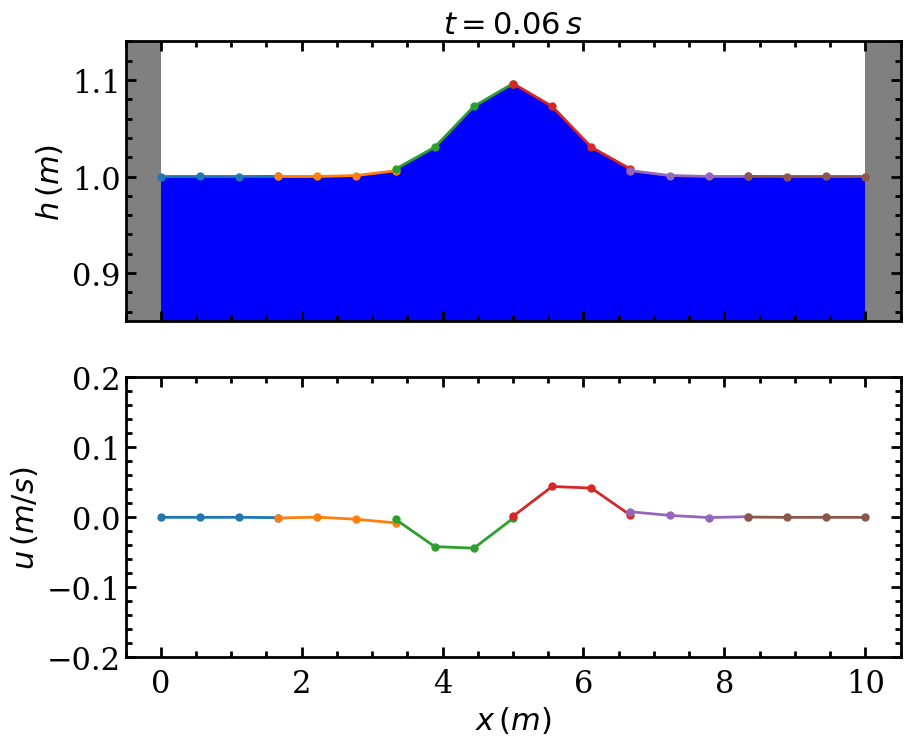

In [10]:
# calcula la matriz de rigidez S_ij = integral (dphi_i(x)/dx)phi_j(x) dx
matriz_de_rigidez = discontinuos_galerkin.calcula_matrix_de_rigidez(longitud_elemento, pesos_de_gauss, polinomios_de_lagrange_en_cuadratura_de_gauss, derivada_x_polinomios_de_lagrange_en_cuadratura_de_gauss)

# time step
time_step = np.array(t_total/n_pasos) 

# evolving in time the PDE
for number_of_t_step in np.arange(n_pasos):

    # Fordward euler time stepping method
    h, u = time_stepping.euler_method( h, u, time_step, matriz_de_masa_inversa, matriz_de_rigidez)

    # RK4 time stepping method
    # h, u = integrator.rk4_method( h, u, time_step, matriz_de_masa_inversa)

    # plotting
    plots.plot_simulation(malla, h, u, N_elementos, time_step, number_of_t_step)

print(f'Done')